### Exploring saliency maps for model interpretability 

Saliency maps are a technique used to visualize and interpret which parts of an input (like an image) are most important or "salient" for a model's decision-making process. They essentially show how much each pixel in the image contributes to the model's prediction. In the context of convolutional neural networks (CNNs), saliency maps help to highlight areas in an image that the model "focuses on" when making a classification or prediction.

In [1]:
# Import libraries 
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [2]:
# Define data paths 
DATA_PATHS = {
    "test_dir": "cnn_car_scratch_data/test",
    "model_path": "model_checkpoints/cnn_filter.h5"
}

In [3]:
model = load_model(DATA_PATHS["model_path"])

In [4]:
def preprocess_image(test_dir, test_image):
    img = image.load_img(os.path.join(test_dir, test_image), target_size=(64, 64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x = x / 255.0 
    
    return img, x

In [5]:
def plot_results(images, predictions, overlays=None, cols=5):
    rows = (len(images) + cols - 1) // cols  
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:len(images)]):  
        ax.imshow(images[i])  
        if overlays: ax.imshow(overlays[i], alpha=0.5)  
        ax.set_title(predictions[i]) 
        ax.axis('off')  

    # Hide axes for unused subplots
    for i in range(len(images), len(axes)):
        axes[i].axis('off')  

    plt.tight_layout()
    plt.show()

### Plot Test Predictions

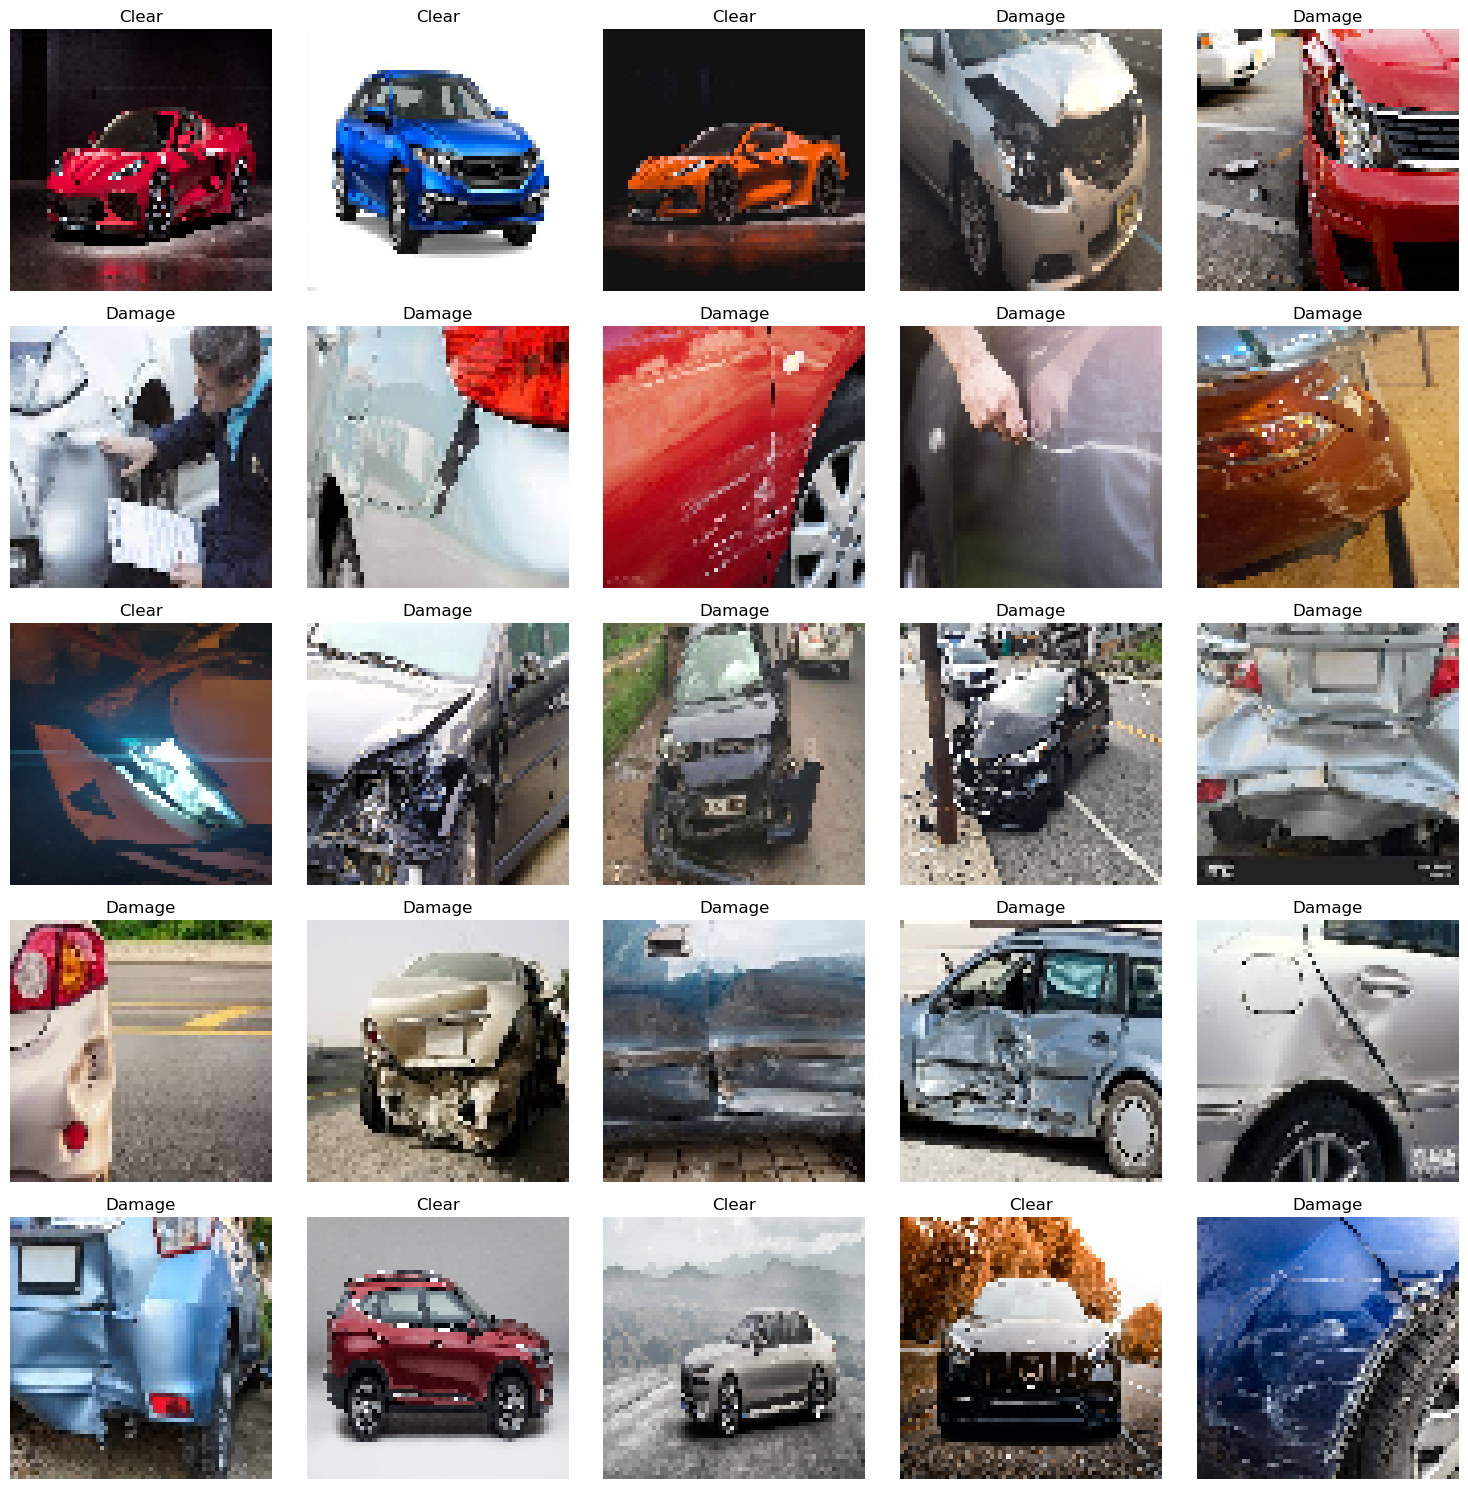

In [6]:
images = []
predictions = []
isDamaged = ['Clear', 'Damage']

for test_image in os.listdir(DATA_PATHS["test_dir"]): 
    img, x = preprocess_image(DATA_PATHS["test_dir"], test_image)
    
    pred = model.predict(x, verbose=0)
    class_idx = np.argmax(pred)

    images.append(img)
    predictions.append(isDamaged[class_idx])

plot_results(images, predictions)

### Compute Saliency Maps

In [7]:
def get_saliency_map(test_image, test_dir):
    img, x = preprocess_image(test_dir, test_image)
    
    # Record operations on the image 
    with tf.GradientTape() as tape:
        tape.watch(x)  
        preds = model(x)
        top_class = preds[:, class_idx]

    # Compute gradients and saliency maps 
    grads = tape.gradient(top_class, x)
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0] 
    saliency_normalized = saliency / np.max(saliency)
    
    # Create an overlay by blending the saliency map with the original image
    overlay = np.uint8(plt.cm.jet(saliency_normalized) * 255) / 255.0
    
    return img, overlay, np.argmax(preds) 

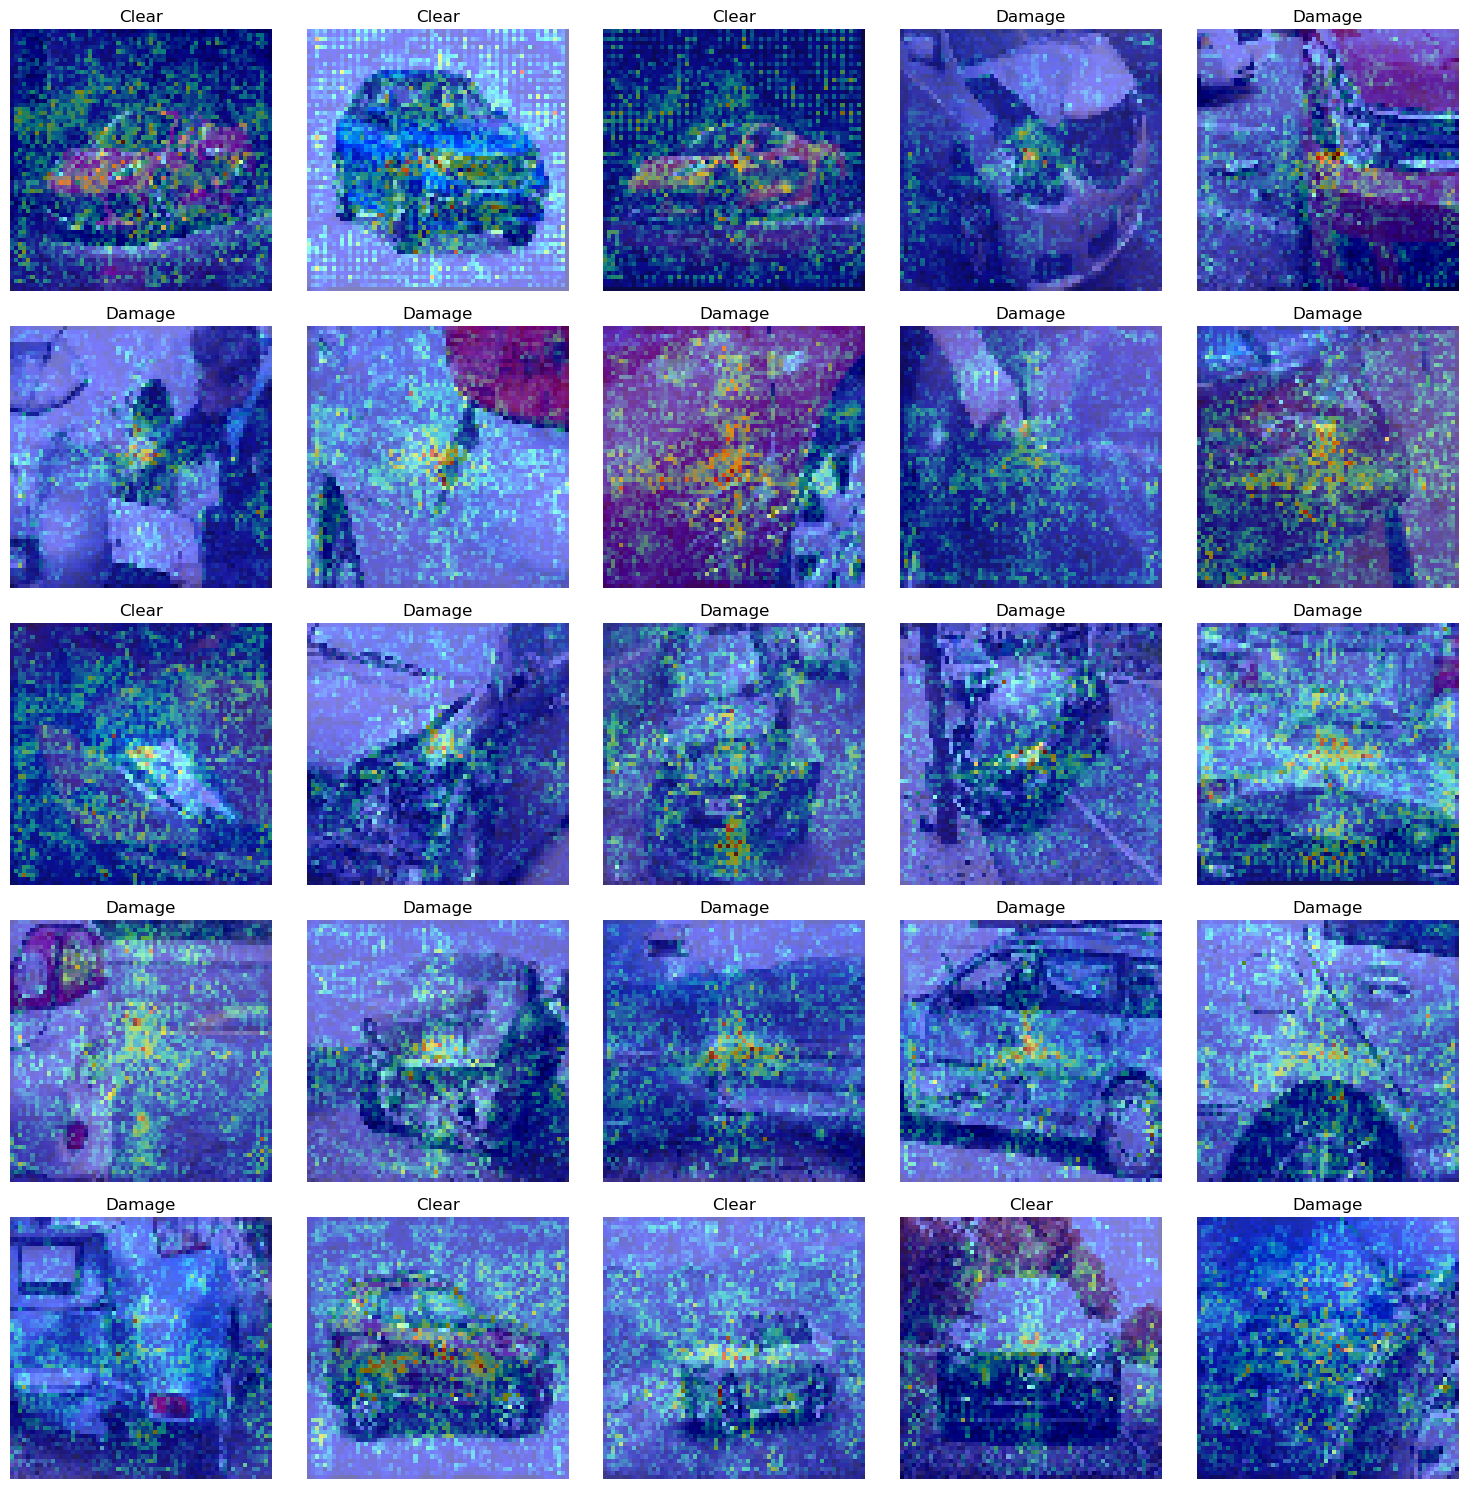

In [8]:
overlays = []
predictions = []
image_arrays = []
isDamaged = ['Clear', 'Damage']

for test_image in os.listdir(DATA_PATHS["test_dir"]):
    img, overlay, preds = get_saliency_map(test_image, DATA_PATHS["test_dir"])
    
    image_arrays.append(img)
    overlays.append(overlay)
    predictions.append(isDamaged[preds])
    
plot_results(image_arrays, predictions, overlays)